# Quick start to KinFragLib

Introduction on how to load and use the KinFragLib fragment library.

## Table of contents

1. Access fragment library
2. View all fragments of a specific inhibitor
3. Identify most common fragments in a subpocket

In [1]:
from pathlib import Path

from IPython.core.display import HTML
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools

from kinfraglib import utils

In [2]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## 1. Access fragment library

In [3]:
# Path to library folder
HERE = Path(_dh[-1])
PATH_TO_LIB = HERE / '../..' / 'data' / 'fragment_library'

In [4]:
# Use utils function to read fragment library
fragment_library = utils.read_fragment_library(PATH_TO_LIB)
fragment_library.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

`fragment_library` is a dictionary containing a `pandas` DataFrame for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the pool X.

The following data is linked to each fragment:

- `ROMol`, `ROMol_dummy`, and `ROMol_original`: RDKit molecules for the 2D representation of the fragment without and with dummy atoms as well as for the 3D representation of the fragment as described in the SDF file from which the data is loaded.
- `kinase`, `family`, and `group`: *Kinase* name, *family* and *group* of the kinase that the ligand (from which the fragment originates) was co-crystallized with
- `complex_pdb`, `ligand_pdb`, `alt`, and `chain`: *PDB complex* and *ligand ID*, *alternate model* and *chain* for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- `atom_subpockets`: Subpocket assignment for each of the fragment's atoms
- `atom_environments`: BRICS environment IDs for each of the fragment's atoms
- `smiles` and `smiles_dummy`: SMILES for the fragment without and with dummy atoms
- `subpocket`: Subpocket assignment for the fragment

### Access fragments in specific subpocket (here AP)

Shape of AP fragment DataFrame:  (3240, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,AP
1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,AP
2,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,AP

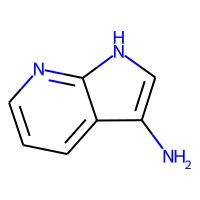
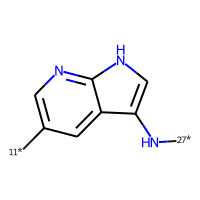
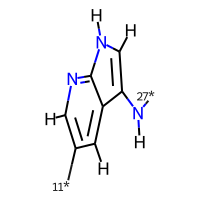
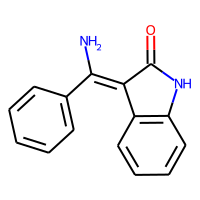
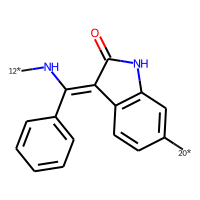
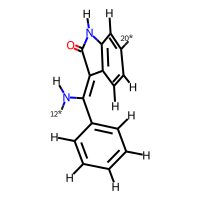
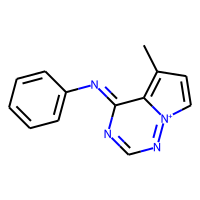
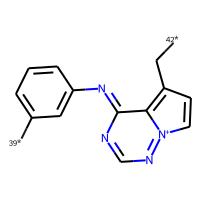
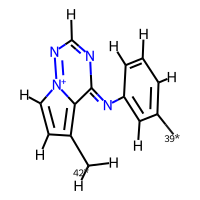

In [5]:
ap_fragments = fragment_library['AP']
print('Shape of AP fragment DataFrame: ', ap_fragments.shape)
HTML(ap_fragments.head().head(3).to_html(notebook=True))

### Draw sample set of fragments (without dummy atoms)

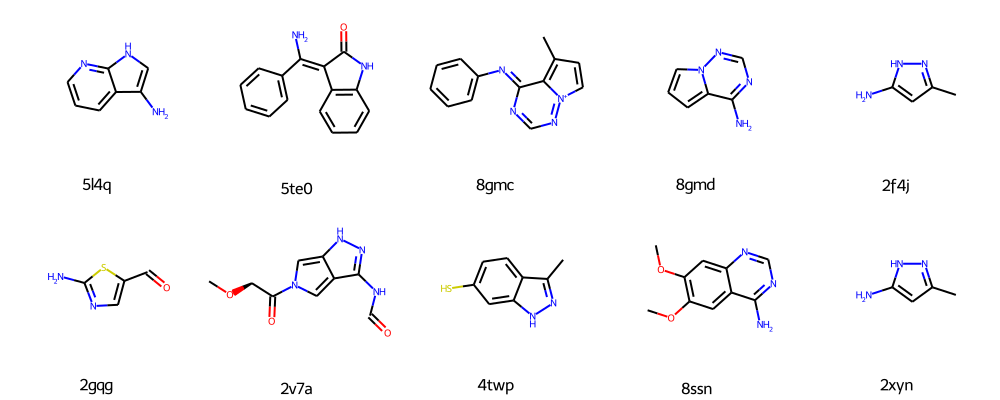

In [6]:
# Draw fragments
Draw.MolsToGridImage(ap_fragments.ROMol[:10], legends=ap_fragments.complex_pdb.to_list(), molsPerRow=5)

### Draw sample set of fragments (with dummy atoms)

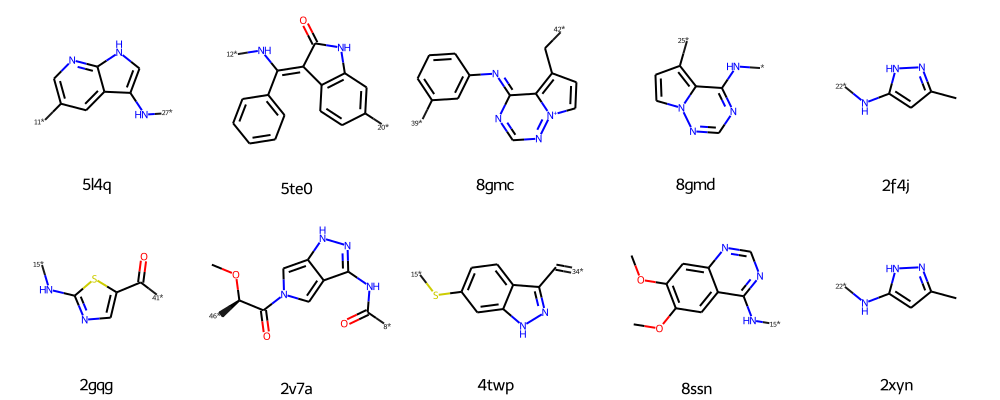

In [7]:
# Draw fragments
Draw.MolsToGridImage(ap_fragments.ROMol_dummy[:10], legends=ap_fragments.complex_pdb.to_list(), molsPerRow=5)

### Show SMILES for sample set of fragments with/without dummy atoms

In [8]:
ap_fragments[['smiles', 'smiles_dummy']].head()
# NBVAL_CHECK_OUTPUT

,smiles,smiles_dummy
0,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1
2,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1
3,Nc1ncnn2cccc12,*Nc1ncnn2ccc([25*])c12
4,Cc1cc(N)[nH]n1,[22*]Nc1cc(C)n[nH]1


## 2. View all fragments of a specific inhibitor (here Gefitinib; PDB identifier: IRE)

This analysis could be used to investigate, how different orientations/binding modi of the same molecules co-crystallized to different structures affects the subpocket assignment.

### Find IRE fragments in each subpocket

In [9]:
ire_fragments = utils.get_fragments_by_ligand('IRE', fragment_library)

print(f'Number of fragments from IRE ligands: {ire_fragments.shape[0]}')

ire_kinases = list(ire_fragments.kinase.unique())
ire_pdbs = list(ire_fragments.complex_pdb.unique())
print(f'Kinases the ligand bind to: {ire_kinases}')
print(f'Ligand co-crystallized in structures with PDB IDs: {ire_pdbs}')
# NBVAL_CHECK_OUTPUT

Number of fragments from IRE ligands: 30
Kinases the ligand bind to: ['EGFR', 'GAK']
Ligand co-crystallized in structures with PDB IDs: ['2ito', '2ity', '2itz', '3ug2', '4i22', '4wkq', '5y7z', '5y80']


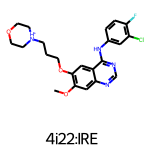

In [10]:
# Draw full ligand
utils.draw_ligands_from_pdb_ids(ire_pdbs[4], 'IRE')

### Draw sample ligand fragmentation

Draw fragments for PDB structure 2ito and ligand IRE


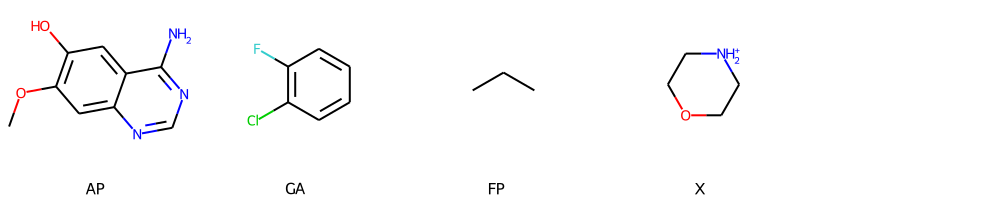

In [11]:
complex_pdb = ire_fragments.iloc[0].complex_pdb
ligand_pdb = ire_fragments.iloc[0].ligand_pdb

print(f'Draw fragments for PDB structure {complex_pdb} and ligand {ligand_pdb}')
utils.draw_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)

Draw fragments for PDB structure 2ito and ligand IRE including dummy atoms


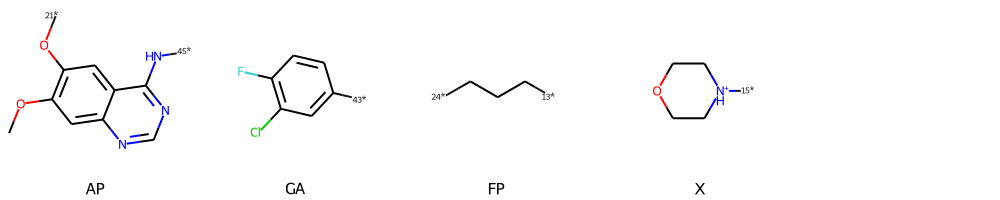

In [12]:
print(f'Draw fragments for PDB structure {complex_pdb} and ligand {ligand_pdb} including dummy atoms')
utils.draw_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5, include_dummy=True)

### Draw fragmentation for all ligands (sorted by subpocket)

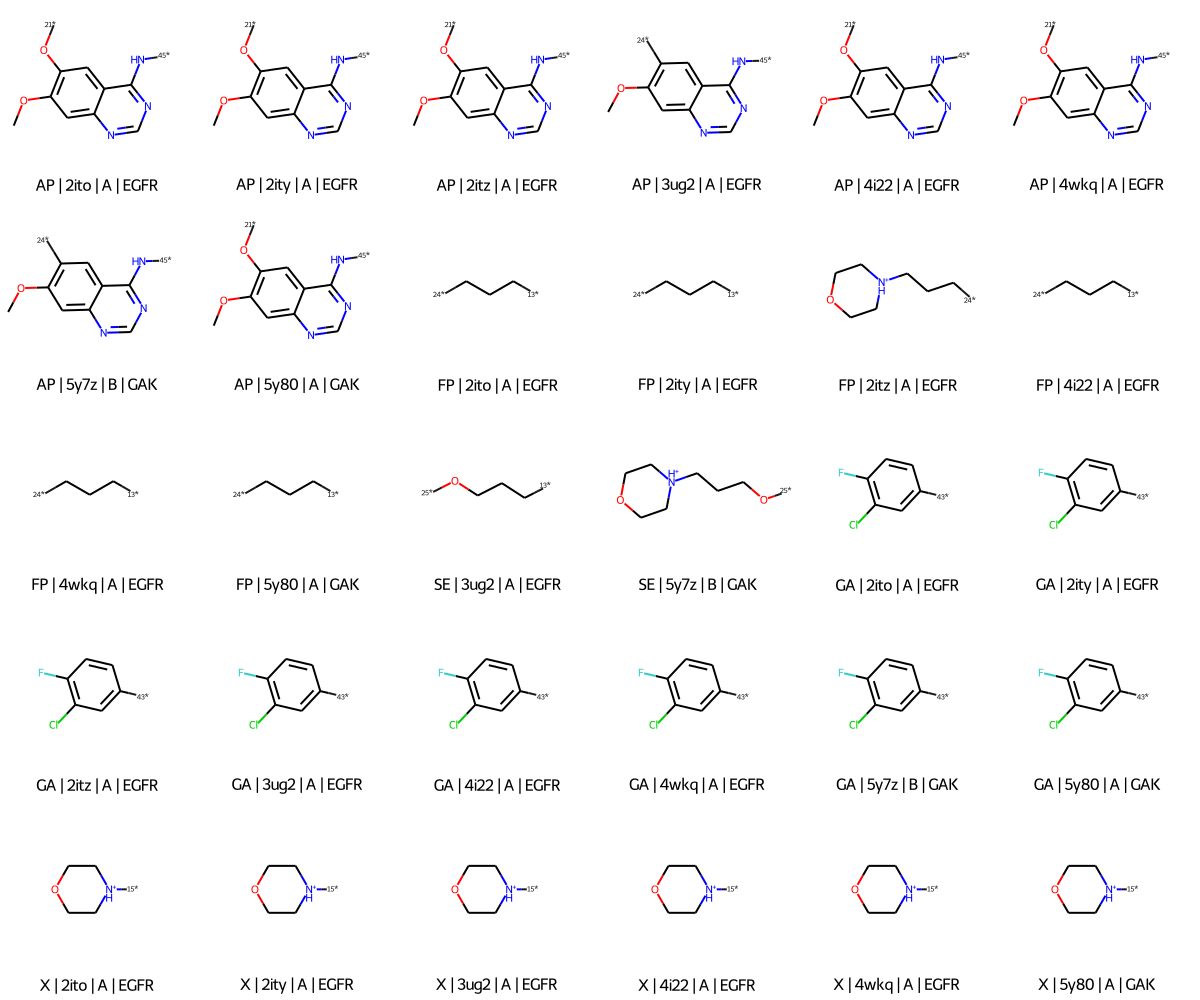

In [13]:
Draw.MolsToGridImage(
    [
        fragment.ROMol_dummy
        for index, fragment 
        in ire_fragments.iterrows()
    ], 
    legends=[
        f"{fragment.subpocket} | {fragment.complex_pdb} | {fragment.chain} | {fragment.kinase}"
        for index, fragment 
        in ire_fragments.iterrows()
    ], 
    molsPerRow=6
)

**Discussion**

The above figure shows:
* The hinge binding fragments clearly lie in AP in all structures, only difference 
    - Neighboring oxygen is in most structures part of AP
    - In some structures it was assigned to FP (3ug2, 5y7z)
* The halogenetated benzene ring is clearly assigned to GA in all structures
* In contrast the long solvent exposed tail is very flexible, and can thus, be assigned to
    - FP or SE 
    - and even be further split, with the terminal ring being annotated to pool X

## 3. Identify most common fragments in a subpocket (here AP)

In [14]:
# Use utils function to count fragment occurances
most_common_fragments_df = utils.get_most_common_fragments(ap_fragments, top_x=25)

,smiles,fragment_count,ROMol
molecule_id,,,
0,Nc1ncccn1,133,
1,c1ccncc1,57,
2,COc1cc(-c2cnccc2C)cc(OC)c1OC,46,

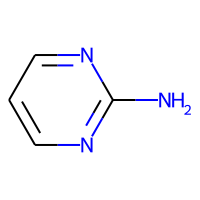
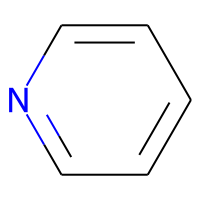
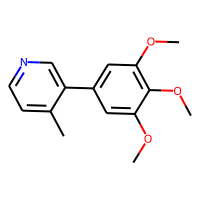

In [15]:
HTML(most_common_fragments_df.head(3).to_html(notebook=True))

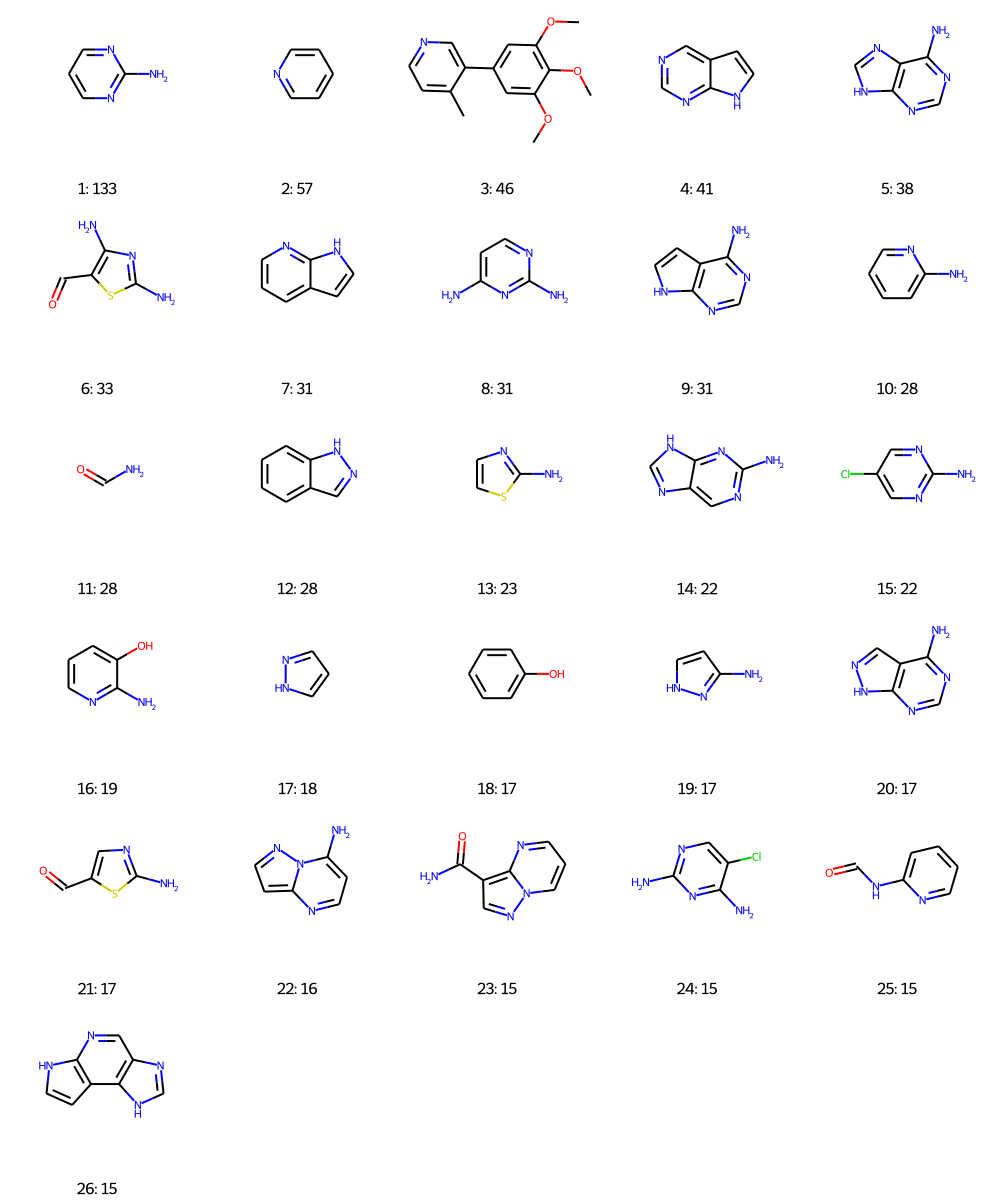

In [16]:
Draw.MolsToGridImage(
    most_common_fragments_df.ROMol, 
    legends=[f'{i+1}: {x}' for i, x in enumerate(most_common_fragments_df.fragment_count)], 
    molsPerRow=5
)

### Analyze the occurences of a specific fragment 

Select a fragment from the AP most common fragments.

In [17]:
query_smiles = Chem.MolToSmiles(most_common_fragments_df.ROMol[0])
print(query_smiles)
# NBVAL_CHECK_OUTPUT

Nc1ncccn1


In [18]:
ap_fragments_subset = ap_fragments[ap_fragments.smiles==query_smiles]

Collect complexes containing this fragment.

In [19]:
print(f'List of pdb codes, from which the fragment originated:\n{ap_fragments_subset.complex_pdb.to_list()}')
# NBVAL_CHECK_OUTPUT

List of pdb codes, from which the fragment originated:
['4dce', '4fnz', '6acr', '6jux', '7c3g', '7nns', '7ayi', '4xv2', '4xv3', '5csw', '5hie', '6v2u', '7p3v', '6w07', '7lty', '7ltz', '6gu3', '6gu7', '1h01', '1oir', '1oit', '1pxi', '1pxj', '1pxl', '1pxm', '1pxn', '1pxo', '1pxp', '1urw', '2c5n', '2c5o', '2c5v', '2uue', '2w05', '2w06', '2wev', '2xmy', '2xnb', '3ej1', '3sw4', '3sw7', '3unj', '4ek8', '4fkl', '4fko', '5iev', '5iey', '5k4j', '6gue', '6guh', '7ra5', '3uyt', '3uzp', '4tn6', '6gro', '6r3d', '6r8j', '6zln', '4zau', '6lud', '4fux', '4xj0', '5bvd', '5bve', '5bvf', '5k4i', '5ngu', '5nhf', '5nhh', '5nhj', '5nhp', '5nhv', '6gjb', '6oph', '6rq4', '3bz3', '6yq1', '3du8', '3qqu', '4d2r', '4u6r', '6w39', '6w3a', '6w3e', '7bmk', '6dbn', '4bbe', '4bbf', '4d0w', '4d0x', '4d1s', '4hys', '4hyu', '4izy', '1pmn', '3cgo', '3kvx', '4kkh', '4u79', '3cjg', '4c3f', '6z1q', '6z1t', '4o0t', '4o0v', '7cmb', '7cp3', '7cp4', '4a4l', '4a4o', '5ar8', '1y57', '1xbb', '3emg', '4rss', '4xg7', '4xg9', '4yjp', 

Investigate individual ligands from this set.

Draw fragments for PDB structure 4dce  and ligand 0JF


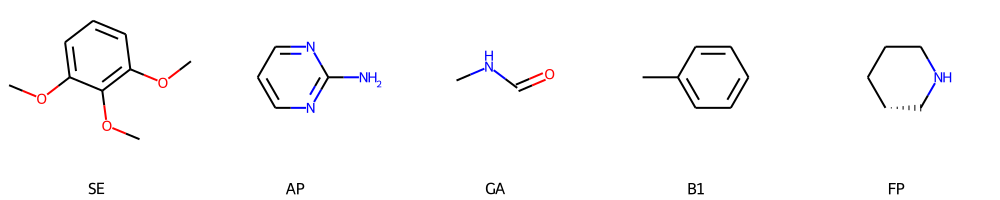

In [20]:
ap_fragments_subset_example = ap_fragments_subset.iloc[0]

pdb = ap_fragments_subset_example.complex_pdb
ligand = ap_fragments_subset_example.ligand_pdb

print('Draw fragments for PDB structure', pdb, ' and ligand', ligand)
utils.draw_fragmented_ligand(fragment_library, pdb, ligand, mols_per_row=5)

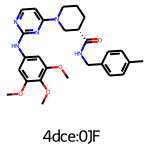

In [21]:
# Draw full ligand
utils.draw_ligands_from_pdb_ids('4dce', '0JF')